https://flopy.readthedocs.io/en/3.3.2/_notebooks/tutorial01_mf6.html

In [17]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
import os
from datetime import datetime

from tempfile import TemporaryDirectory
from tempfile import mkdtemp

import os
import platform
import subprocess
import numpy as np

In [18]:
myt = datetime.now().strftime('%m%d%H%M%S')
name = 'wasaga'
temp_dir = mkdtemp(prefix='_T{}_{}_'.format(myt,name))
os.makedirs(Path(temp_dir) / '_output')
model_ws = temp_dir


def open_file(path):
    if platform.system() == "Windows":
        os.startfile(path)
    elif platform.system() == "Darwin":
        subprocess.Popen(["open", path])
    else:
        subprocess.Popen(["xdg-open", path])

open_file(model_ws)

In [61]:
name = "wasaga_mf6"
h1 = 100
h2 = 90
Nlay = 120
N = 440

L = 400.0
H = 50.0
k = 1.0

In [ ]:
name = "wasaga_mf6"

# Define model dimensions
nlay = int(60*2)
nrow = int(220*2)
ncol = int(220*2)
delr = 2200/nrow  # Cell width along rows (extend 2200 / 220)
delc = 2200/ncol  # Cell width along columns (extend 2200 / 220)

# Define top elevation
top_elev = 190.0

# Define layer thickness (uniform thickness)
layer_thickness = 30.0 / nlay

perlen = 365
nper = int(1)
nstp = np.repeat(1,nper)
steady = np.append(np.array([True]),np.repeat(False,nper-1))
#steady=[False,False,True]

In [47]:
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="mf6", version="mf6", sim_ws=model_ws)

In [48]:
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=1, perioddata=[(1.0, 1, 1.0)]
)

In [49]:
ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE")

In [50]:
model_nam_file = "{}.nam".format(name)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

In [51]:
bot = np.linspace(-H / Nlay, -H, Nlay)
delrow = delcol = L / (N - 1)
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=Nlay,
    nrow=N,
    ncol=N,
    delr=delrow,
    delc=delcol,
    top=0.0,
    botm=bot,
)

In [52]:
start = h1 * np.ones((Nlay, N, N))
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

In [53]:
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k, save_flows=True)

In [54]:
chd_rec = []
chd_rec.append(((0, int(N / 4), int(N / 4)), h2))
for layer in range(0, Nlay):
    for row_col in range(0, N):
        chd_rec.append(((layer, row_col, 0), h1))
        chd_rec.append(((layer, row_col, N - 1), h1))
        if row_col != 0 and row_col != N - 1:
            chd_rec.append(((layer, 0, row_col), h1))
            chd_rec.append(((layer, N - 1, row_col), h1))
chd = flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True,
)

In [55]:
iper = 0
ra = chd.stress_period_data.get_data(key=iper)
ra

rec.array([((0, 110, 110),  90.), ((0, 0, 0), 100.), ((0, 0, 439), 100.),
           ..., ((119, 439, 438), 100.), ((119, 439, 0), 100.),
           ((119, 439, 439), 100.)],
          dtype=[('cellid', 'O'), ('head', '<f8')])

In [56]:
# Create the output control (`OC`) Package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [57]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model tutorial01_mf6...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
    writing package oc...


In [60]:
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following executable to run the model: C:\Users\swan47\AppData\Local\flopy\bin\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Apr 12 2023 19:05:25 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the U

TypeError: Length of x (440) must match number of columns in z (101)

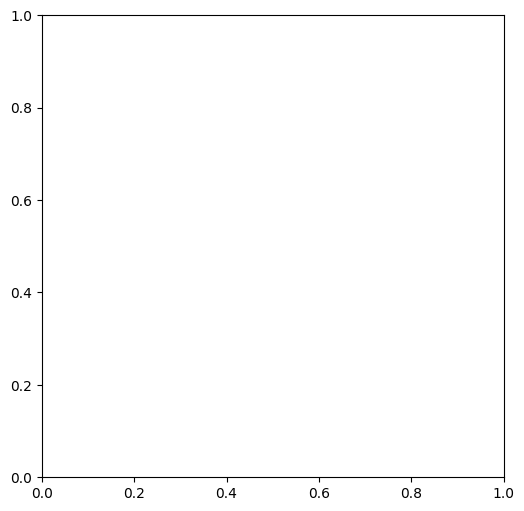

In [59]:
hds = flopy.utils.binaryfile.HeadFile(headfile)
h = hds.get_data(kstpkper=(0, 0))
x = y = np.linspace(0, L, N)
y = y[::-1]
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], np.arange(90, 100.1, 0.2), colors="black")
plt.clabel(c, fmt="%2.1f")